In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('dataset.csv')
df = df[df.Stock == 'A']

k=5 #Max lags

X = pd.DataFrame()
X.loc[:,'Day'] = df.loc[:,'Day'].iloc[0:-k].reset_index(drop=True)
y = df['y'].iloc[k:].reset_index(drop=True)
y2 = df['Return'].iloc[k:].reset_index(drop=True)

for i in range(k):
        X.loc[:,('Lag %i' % (i+1))] = df.loc[:,'Average'].iloc[k-1-i:-1-i].reset_index(drop=True)
        
split_var = int(X.shape[0]/4*3)
X_train, X_test, y_train, y_test = [X.iloc[:split_var,:],X.iloc[split_var:,:],y.iloc[:split_var],y.iloc[split_var:]]

## exporting file to use in R
X_train.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")

In [3]:
X_train.head()

,Day,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
0,0.166667,0.755849,0.752507,0.733739,0.720884,0.711972
1,0.333333,0.755249,0.755849,0.752507,0.733739,0.720884
2,0.500000,0.766561,0.755249,0.755849,0.752507,0.733739
3,0.666667,0.752250,0.766561,0.755249,0.755849,0.752507
4,0.000000,0.734510,0.752250,0.766561,0.755249,0.755849


In [4]:
size = k+1
hidden_layers = 1000

In [5]:
vb = tf.placeholder("float", [size])
hb = tf.placeholder("float", [hidden_layers])

In [6]:
W = tf.placeholder("float", [size, hidden_layers])

In [7]:
X = tf.placeholder("float", [None, size])
_h0 = tf.nn.sigmoid(tf.matmul(X, W) + hb)  #probabilities of the hidden units
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) #sample_h_given_X

In [8]:
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1)))) #sample_v_given_h
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [9]:
alpha = 0.001
w_pos_grad = tf.matmul(tf.transpose(X), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(X)[0])
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(X - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [10]:
err = tf.reduce_mean(tf.square(X - v1))

In [11]:
cur_w = np.zeros([size, hidden_layers], np.float64)
cur_vb = np.zeros([size], np.float64)
cur_hb = np.zeros([hidden_layers], np.float64)
prv_w = np.zeros([size, hidden_layers], np.float64)
prv_vb = np.zeros([size], np.float64)
prv_hb = np.zeros([hidden_layers], np.float64)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [12]:
print("first error ", sess.run(err, feed_dict={X: X_train, W: prv_w, vb: prv_vb, hb: prv_hb}))

first error  0.333394


Epoch: 0 reconstruction error: 0.329707
Epoch: 1 reconstruction error: 0.327335
Epoch: 2 reconstruction error: 0.322618
Epoch: 3 reconstruction error: 0.311918
Epoch: 4 reconstruction error: 0.314025
Epoch: 5 reconstruction error: 0.310922
Epoch: 6 reconstruction error: 0.321064
Epoch: 7 reconstruction error: 0.307390
Epoch: 8 reconstruction error: 0.307825
Epoch: 9 reconstruction error: 0.312361
Epoch: 10 reconstruction error: 0.307421
Epoch: 11 reconstruction error: 0.306059
Epoch: 12 reconstruction error: 0.303252
Epoch: 13 reconstruction error: 0.307458
Epoch: 14 reconstruction error: 0.309697
Epoch: 15 reconstruction error: 0.297828
Epoch: 16 reconstruction error: 0.302738
Epoch: 17 reconstruction error: 0.303312
Epoch: 18 reconstruction error: 0.295310
Epoch: 19 reconstruction error: 0.303232
Epoch: 20 reconstruction error: 0.299974
Epoch: 21 reconstruction error: 0.299751
Epoch: 22 reconstruction error: 0.296910
Epoch: 23 reconstruction error: 0.298216
Epoch: 24 reconstruction e

Epoch: 199 reconstruction error: 0.285132


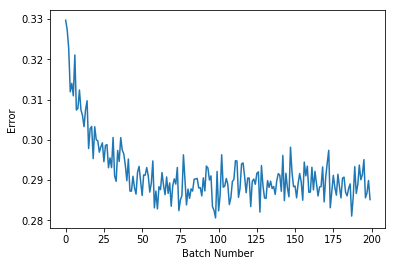

In [13]:
#Parameters
epochs = 200
batchsize = len(X_train)-90
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(X_train), batchsize), range(batchsize, len(X_train), batchsize)):
        batch = X_train[start:end]
        cur_w = sess.run(update_w, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={  X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={X: X_train, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print('Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

## Constructing the output

In [23]:
hh0 = tf.nn.sigmoid(tf.matmul(X_train.astype(np.float32), W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ X: X_train, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [25]:
rec.shape

(940, 6)